# Show Me the Orbit

Sarah Blunt (2019)

This is some code I wrote to define the `orbitize!` coordinate system and help users visualize orbits. 

### Scroll to the bottom of the page to interact with my visualization!

<IPython.core.display.Javascript object>


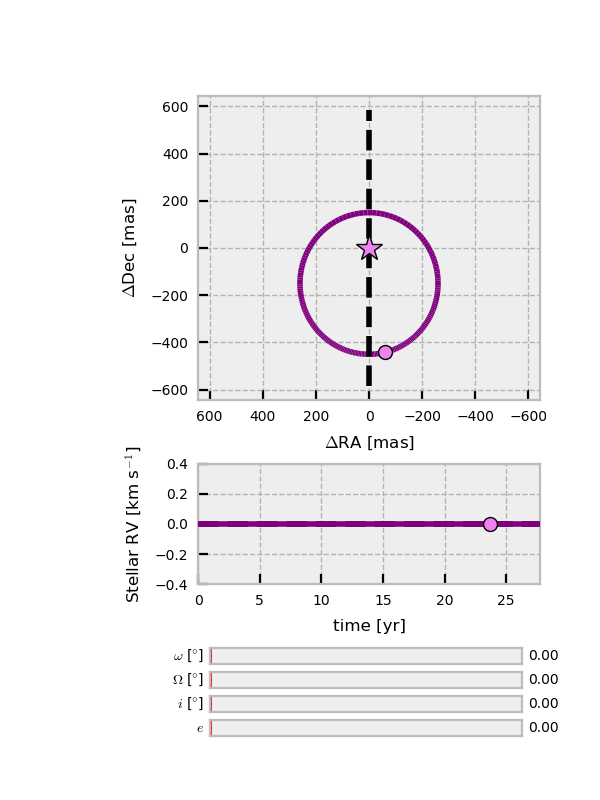

In [3]:
%matplotlib notebook

import numpy as np
import time

import astropy.units as u
import astropy.constants as consts

import matplotlib as mpl
mpl.style.use('bmh')

import matplotlib.pyplot as plt
from matplotlib import animation, rcParams
from matplotlib.widgets import Slider
from matplotlib.collections import LineCollection

import orbitize.kepler

class Orbit(object):
    """ Initializes an interactive matplotlib figure illustrating how eccentricity, 
        argument of periastron, inclination, and position angle of nodes affect an orbit.
        
    Args:
        sma: semimajor axis (default: 10) [au]
        tau: epoch of periastron passage, expressed as a fraction of orbital period past MJD=0 (default: 0.3)
        plx: parallax (default: 30) [mas]
        mtot: total mass of system (default: 1.3) [Msol]
        time_divs: number of epochs at which to compute position & radial velocity (default: 500)
        mplanet: planet mass (default: 0.01) [Msol]
    """

    def __init__(
        self, sma=10, tau=0.3, plx=30, mtot=1.3, time_divs=200, mplanet=0.01
    ):
        self.sma = sma
        self.ecc = 0.5
        self.inc = 0
        self.aop = 0
        self.pan = 0
        self.tau = tau
        self.plx = plx
        self.mtot = mtot
        self.mplanet = mplanet
        self.time_divs = time_divs
        
        max_ecc = 0.95 # max eccentrity for slider
        
        # calculate related quantities
        self.per_yr = np.sqrt(self.sma**3/self.mtot)
        self.per_days = self.per_yr*365.25
        self.max_sep_mas = self.sma*(1+max_ecc)*self.plx 
        self.min_sep_mas = self.sma*(1-max_ecc)*self.plx 
        self.maxK = (
            np.sqrt(consts.G / (1.0 - max_ecc**2)) * 
            (self.mplanet * u.Msun) / np.sqrt(self.mtot * u.Msun) / 
            np.sqrt(self.sma * u.au)
        ).to(u.km/u.s).value
        
        # number of epochs at which to solve the orbit
        self.epochs = np.linspace(0, self.per_days, self.time_divs)
        
        # calculate orbital track
        self.ra, self.dec, self.rv = orbitize.kepler.calc_orbit(
            self.epochs, self.sma, self.ecc, np.radians(self.inc), np.radians(self.aop), 
            np.radians(self.pan), self.tau, self.plx, self.mtot, mass_for_Kamp=self.mplanet
        )
        self.rv *= -1 # stellar RVs must be multiplied by -1
        
        # RA/Dec for inc=aop=pan=0 (useful for calculating z(t))
        self.ra0 = self.ra
        self.dec0 = self.dec
        
        # calculate z(t)
        self.z = np.sin(np.radians(self.inc)) * (
            np.cos(np.radians(self.aop))*self.ra0 + 
            np.sin(np.radians(self.aop))*self.dec0
        ) * self.plx
        
        # set up plot
        rcParams.update({'font.size': 5})
        self.fig, self.ax = plt.subplots(figsize=(3,4), dpi=250)
        self.ax.set_ylim(-1.1*self.max_sep_mas, 1.1*self.max_sep_mas)
        self.ax.set_xlim(1.1*self.max_sep_mas, -1.1*self.max_sep_mas)
        self.ax.set_ylabel('$\Delta$Dec [mas]')
        self.ax.set_xlabel('$\Delta$RA [mas]')
        plt.subplots_adjust(left=0.33, bottom=0.5)
        
        # plot orbit track
        self.purple = (0.5019607843137255, 0.0, 0.5019607843137255, 1.0)
        self.lightpurp = (0.5019607843137255, 0.0, 0.5019607843137255, 0.1)
        
        points = np.array([self.ra, self.dec]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        self.color = np.empty(len(self.epochs), dtype=(float,4))
        self.color[self.z < 0] = self.lightpurp
        self.color[self.z >= 0] = self.purple

        self.lc = LineCollection(segments, color=self.color)
        _ = self.ax.add_collection(self.lc)
                
        # plot location of star
        self.star = self.ax.plot([0],[0], marker='*',
            color='violet', markersize=10, zorder=5, markeredgecolor='black', markeredgewidth=0.5
        )[0]
        
        # plot line of nodes
        lineofnodes_x = [
            -np.sin(np.radians(self.pan))*self.max_sep_mas, 
            np.sin(np.radians(self.pan))*self.max_sep_mas
        ]
        lineofnodes_y = [
            -np.cos(np.radians(self.pan))*self.max_sep_mas, 
            np.cos(np.radians(self.pan))*self.max_sep_mas
        ]
        self.lineofnodes = self.ax.plot(
            lineofnodes_x, lineofnodes_y, 
            linestyle='--', color='k'
        )[0]
        
        # plot location of planet
        self.planet_loc = self.ax.plot(
            self.ra[0], self.dec[0], 
            marker='o', markersize=5, zorder=5, color='violet', markeredgecolor='black', markeredgewidth=0.5
        )[0]
        
        # plot RV vs time
        self.ax_rv = plt.axes([0.33, .27, 0.57, 0.15])
        self.ax_rv.set_xlim(self.epochs[0]/365.25, self.epochs[-1]/365.25)
        self.ax_rv.set_ylim(-1.5*self.maxK, 1.5*self.maxK)
        self.ax_rv.set_xlabel('time [yr]')
        self.ax_rv.set_ylabel('Stellar RV [km s$^{-1}$]')
        self.planet_rv_track = self.ax_rv.plot(self.epochs/365.25, self.rv, color='purple', zorder=4)[0]
        self.ax_rv.plot([self.epochs[0]/365.25, self.epochs[-1]/365.25], [0,0], linestyle='--', color='k')
        self.planet_rv = self.ax_rv.plot(
            self.epochs[0]/365.25, self.rv[0], marker='o', markersize=5, zorder=5, 
            color='violet', markeredgecolor='black', markeredgewidth=0.5
        )[0]
    
        # add inc slider
        ax_inc = plt.axes([0.35, .11, 0.52, 0.02])
        self.inc_slider = Slider(
            ax_inc, '$i$ [$\degree$]', 0, 180, valinit=0, valstep=1, facecolor='purple'
        )
        self.inc_slider.on_changed(self.update_inc)
        
        # add PAN slider
        ax_pan = plt.axes([0.35, .14, 0.52, 0.02])
        self.pan_slider = Slider(
            ax_pan, '$\Omega$ [$\degree$]', 0, 360, valinit=0, valstep=1, facecolor='purple'
        )
        self.pan_slider.on_changed(self.update_pan)
        
        # add AOP slider
        ax_aop = plt.axes([0.35, .17, 0.52, 0.02])
        self.aop_slider = Slider(
            ax_aop, '$\omega$ [$\degree$]', 0, 360, valinit=0, valstep=1, facecolor='purple'
        )
        self.aop_slider.on_changed(self.update_aop)
        
        # add eccentricity slider
        ax_ecc = plt.axes([0.35, .08, 0.52, 0.02])
        self.ecc_slider = Slider(
            ax_ecc, '$e$', 0, max_ecc, valinit=0, valstep=.01, facecolor='purple'
        )
        self.ecc_slider.on_changed(self.update_ecc)
    
    def update_orbit(self):
        
        # calculate z(t)
        self.z = np.sin(np.radians(self.inc)) * (
            -np.cos(np.radians(self.aop))*self.ra0 - 
            np.sin(np.radians(self.aop))*self.dec0
        ) * self.plx
                
        # set orbit track
        points = np.array([self.ra, self.dec]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        self.color[self.z < 0] = self.lightpurp
        self.color[self.z >= 0] = self.purple

        self.lc.set_segments(segments)
        self.lc.set_color(self.color)
        
    def update_ecc(self, val):

        self.ecc = val

        # recalculate orbital track
        self.ra, self.dec, self.rv = orbitize.kepler.calc_orbit(
            self.epochs, self.sma, self.ecc, np.radians(self.inc), np.radians(self.aop), 
            np.radians(self.pan), self.tau, self.plx, self.mtot, mass_for_Kamp=self.mplanet
        )
        self.rv *= -1 # stellar RVs must be multiplied by -1
        self.planet_rv_track.set_data(self.epochs/365.25, self.rv)
        
        # recalculate ra0 & dec0
        self.ra0, self.dec0, _ = orbitize.kepler.calc_orbit(
            self.epochs, self.sma, self.ecc, 0, 0, 
            0, self.tau, self.plx, self.mtot, mass_for_Kamp=self.mplanet
        )
        
        # update orbit track
        self.update_orbit()
        
    
    def update_inc(self, val):

        self.inc = val

        # recalculate orbital track
        self.ra, self.dec, self.rv = orbitize.kepler.calc_orbit(
            self.epochs, self.sma, self.ecc, np.radians(self.inc), np.radians(self.aop), 
            np.radians(self.pan), self.tau, self.plx, self.mtot, mass_for_Kamp=self.mplanet
        )
        self.rv *= -1 # stellar RVs must be multiplied by -1
        self.planet_rv_track.set_data(self.epochs/365.25, self.rv)
        
        # update orbit track
        self.update_orbit()
    
    def update_aop(self, val):

        self.aop = val

        # recalculate orbital track
        self.ra, self.dec, self.rv = orbitize.kepler.calc_orbit(
            self.epochs, self.sma, self.ecc, np.radians(self.inc), np.radians(self.aop), 
            np.radians(self.pan), self.tau, self.plx, self.mtot, mass_for_Kamp=self.mplanet
        )
        self.rv *= -1 # stellar RVs must be multiplied by -1
                
        # recalculate RV track
        self.planet_rv_track.set_data(self.epochs/365.25, self.rv)
        
        # update orbit track
        self.update_orbit()
        
    def update_pan(self, val):

        self.pan = val

        # recalculate orbital track
        self.ra, self.dec, self.rv = orbitize.kepler.calc_orbit(
            self.epochs, self.sma, self.ecc, np.radians(self.inc), np.radians(self.aop), 
            np.radians(self.pan), self.tau, self.plx, self.mtot, mass_for_Kamp=self.mplanet
        )
        self.rv *= -1 # stellar RVs must be multiplied by -1
        
        lineofnodes_x = [
            -np.sin(np.radians(self.pan))*self.max_sep_mas, 
            np.sin(np.radians(self.pan))*self.max_sep_mas
        ]
        lineofnodes_y = [
            -np.cos(np.radians(self.pan))*self.max_sep_mas, 
            np.cos(np.radians(self.pan))*self.max_sep_mas
        ]
        
        # update line of nodes
        self.lineofnodes.set_data(lineofnodes_x, lineofnodes_y)
        
        # update orbit track
        self.update_orbit()
        
    def advance_orbit_pos(self, index):
        """ Moves the planet along its orbit to the next epoch.
        
        Args:
            index: new epoch index
        """
        
        # advance orbit position
        self.planet_loc.set_data(
            self.ra[index], self.dec[index]
        )
        
        self.planet_rv.set_data(
            self.epochs[index]/365.25, self.rv[index]
        )
    
    def animate(self, interval=5):
        """ Continuously advance the planet's orbital location.
        
        Args:
            interval: delay between frames [milliseconds]
        """ 
        
        frames=np.arange(self.time_divs)
        self.anim = animation.FuncAnimation(
            self.fig, self.advance_orbit_pos, frames=np.arange(self.time_divs),
            interval=interval
        )
        return self.anim

myOrbit = Orbit()
_ = myOrbit.animate()